In [1]:
import pandas as pd
import numpy as np
import os
import time
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(base_path, "data", "processed", "diplomacy")

model_dir = os.path.join(base_path, "models", "deceptency") 
model_path = os.path.join(model_dir, 'bert_diplomacy')

In [3]:
# Load Data
train_df = pd.read_parquet(os.path.join(data_path, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(data_path, "val_processed.parquet"))
test_df = pd.read_parquet(os.path.join(data_path, "test_processed.parquet"))

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (13132, 13)
Val shape: (1416, 13)
Test shape: (2741, 13)


## Tokenization
We use the BERT tokenizer to convert text into input IDs and attention masks.

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

def encode_examples(df, limit=-1):
    # Use a subset for testing if limit > 0
    if limit > 0:
        df = df.iloc[:limit]
        
    input_ids = []
    attention_masks = []
    
    for text in df['message_text']:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
        
    return np.array(input_ids), np.array(attention_masks), df['target'].values

# Encode data
print("Encoding data...")
X_train_ids, X_train_mask, y_train = encode_examples(train_df)
X_val_ids, X_val_mask, y_val = encode_examples(val_df)
X_test_ids, X_test_mask, y_test = encode_examples(test_df)

print("Encoding complete.")

Encoding data...
Encoding complete.


In [5]:
try:
    model = TFBertForSequenceClassification.from_pretrained(model_path, use_safetensors=False)
    print(f'Model loaded from {model_path}')
    skip_training = True
except (OSError, EnvironmentError):
    print('No existing model found. Will train a new model.')
    skip_training = False


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at c:\work environment\Projects\amazon-spam-review\models\deceptency\bert_diplomacy.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model loaded from c:\work environment\Projects\amazon-spam-review\models\deceptency\bert_diplomacy


In [6]:
if not skip_training:
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    
    tf.keras.backend.clear_session()
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased', 
        num_labels=1, 
        use_safetensors=False
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    
    print("Starting training...")
    start_time = time.time()
    history = model.fit(
        [X_train_ids, X_train_mask], y_train,
        epochs=3,
        batch_size=16,
        validation_data=([X_val_ids, X_val_mask], y_val),
        class_weight=class_weights_dict
    )
    end_time = time.time()
    training_time_minutes = (end_time - start_time) / 60
    
    # Modeli Kaydet
    os.makedirs(model_dir, exist_ok=True)
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")
else:
    training_time_minutes = 0  # Yüklendiği için eğitim süresi 0
    print('Skipping training and proceeding to evaluation...')

Skipping training and proceeding to evaluation...


In [7]:
y_pred_logits = model.predict([X_test_ids, X_test_mask]).logits
y_pred_prob = tf.sigmoid(y_pred_logits).numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

86/86 [==============================] - 176s 2s/step


In [8]:
report = classification_report(y_test, y_pred, target_names=['Truth', 'Deception'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Truth', 'Deception']))


Classification Report:
              precision    recall  f1-score   support

       Truth       0.93      0.74      0.82      2501
   Deception       0.13      0.42      0.20       240

    accuracy                           0.71      2741
   macro avg       0.53      0.58      0.51      2741
weighted avg       0.86      0.71      0.77      2741



In [9]:
results_file = os.path.join(base_path, "reports", "model_results_deceptency_bert_diplomacy.csv")
os.makedirs(os.path.dirname(results_file), exist_ok=True)

result_data = {
    'category': 'Deceptency_bert_diplomacy',
    'test_accuracy': report['accuracy'],
    'test_f1_truth': report['Truth']['f1-score'],
    'test_precision_truth': report['Truth']['precision'],
    'test_f1_deception': report['Deception']['f1-score'],
    'test_precision_deception': report['Deception']['precision'],
    'training_time_minutes': training_time_minutes,
    'status': 'Newly Trained' if not skip_training else 'Loaded from Disk'
}

result_df = pd.DataFrame([result_data])
header = not os.path.exists(results_file)
result_df.to_csv(results_file, mode='a', header=header, index=False)
print(f"Results saved to {results_file}")

Results saved to c:\work environment\Projects\amazon-spam-review\reports\model_results_deceptency_bert_diplomacy.csv


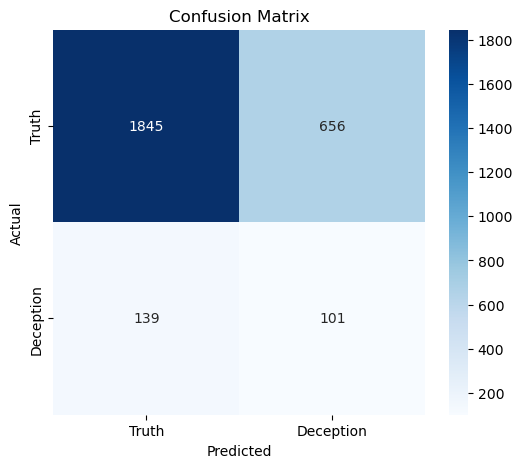

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truth', 'Deception'], yticklabels=['Truth', 'Deception'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()